### What is this?

This is a continuation of the analysis performed in the `real-compression-test-analysis` notebook. In that notebook, the test was performed using an iPhone with heavily compressed files sampled at 16kHz.

This analysis is of the same test but with my Android OnePlus 6 phone recorded in lossless WAV file format sampled at 48kHz.

### Test Results

I recorded the measured compression for each cylinder again. The below results show the compression of each cylinder in both the test from the `real-compression-test-analysis` notebook as well as this test.

| Cylinder | Compression (psi) - iPhone recording | Compression (psi) - Android recording |
|----------|-------------------|-----------------|
| 1        | 180               | 183             |
| 2        | 174               | 178             |
| 3        | 170               | 175             |
| 4        | 186               | 190             |

The results show that there is quite a significant amount of accuracy in the compression test. While the compression differs in both tests, it differs by nearly the same amount in each cylinder and the difference is very small.

In [3]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import signal
import math
from skimage.feature import peak_local_max
from scipy.signal import find_peaks
from librosa import display
from IPython.display import Audio

## Cylinder 1 Recording

In [11]:
#file_path = f"files/tt-04-compression-test/android-cylinder-1.wav"
file_path = "files/tt-04-whistle-tests/baseline.wav"

In [12]:
Audio(file_path)

In [13]:
sr = 48000
samples, sample_rate = librosa.load(file_path, sr=sr, mono=True, offset=0, duration=None)

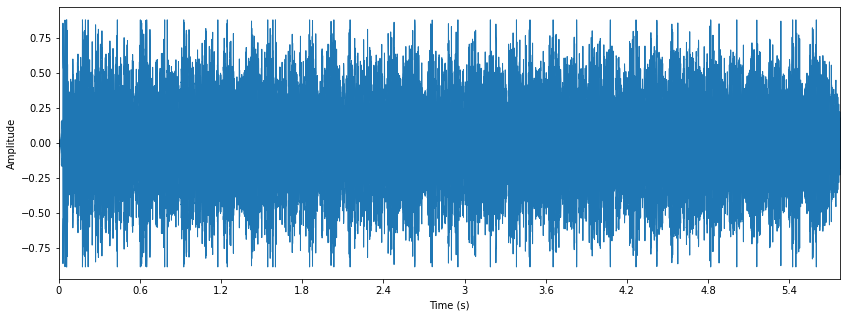

In [14]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y=samples, sr=sample_rate)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

__Frequency Domain__

In [15]:
hop_len = 256
n_fft = 2048
n_mels = 256

S = librosa.stft(samples, n_fft=n_fft, hop_length=hop_len)
freqs = np.arange(0, 1 + n_fft / 2) * sample_rate / n_fft
S_dB = librosa.amplitude_to_db(abs(S))

mel_spec = librosa.feature.melspectrogram(y=samples, sr=sample_rate, n_mels=n_mels, hop_length=hop_len)
mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
mel_freqs = mel = librosa.mel_frequencies(n_mels=n_mels, fmin=0, fmax=sample_rate/2)

/usr/local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/usr/local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


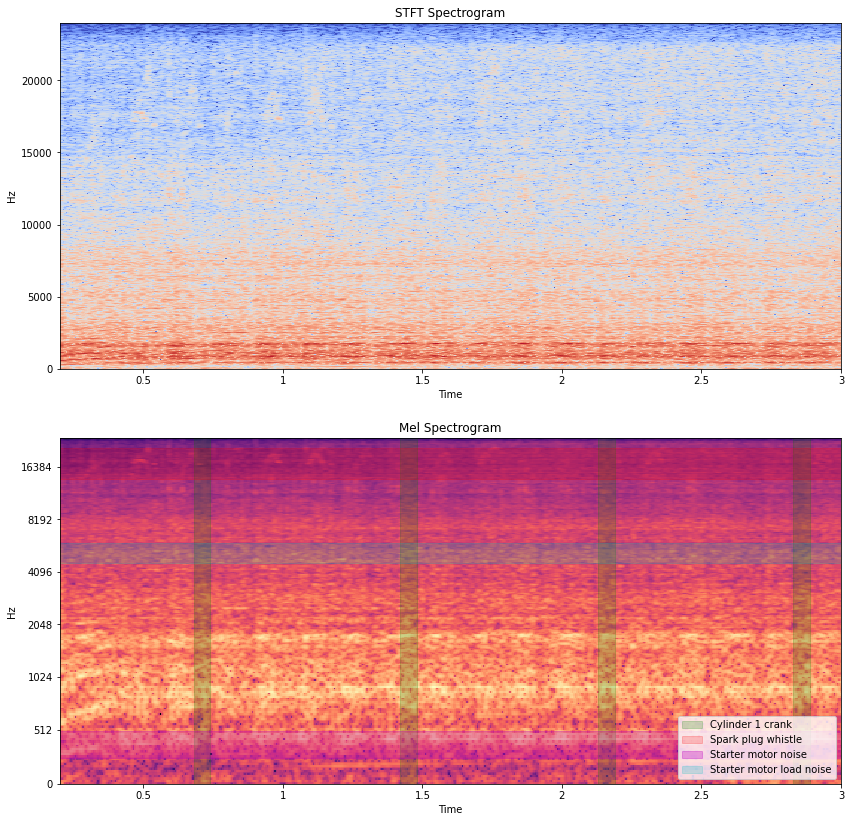

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(14, 14))

ax[0].set_title("STFT Spectrogram")
librosa.display.specshow(S_dB, x_axis='time', y_axis='linear', sr=sample_rate,
                         hop_length=hop_len, ax=ax[0])

ax[0].set_xlim(0.2, 3)

ax[1].set_title("Mel Spectrogram")
librosa.display.specshow(mel_spec_dB, x_axis='time', y_axis='mel', sr=sample_rate, 
                         fmax=sample_rate/2, ax=ax[1], hop_length=hop_len)

ax[1].set_xlim(0.2, 3)

ax[1].axvspan(0.68, 0.74, color='g', alpha=0.2, label='Cylinder 1 crank')
ax[1].axvspan(1.42, 1.48, color='g', alpha=0.2)
ax[1].axvspan(2.13, 2.19, color='g', alpha=0.2)
ax[1].axvspan(2.83, 2.89, color='g', alpha=0.2)

ax[1].axhspan(14000, 21000, color='r', alpha=0.2, label='Spark plug whistle')

ax[1].axhspan(250, 500, color='m', alpha=0.3, label='Starter motor noise')

ax[1].axhspan(4600, 6000, color='c', alpha=0.2, label='Starter motor load noise')

ax[1].legend(loc="lower right")

Because the frequency range is so large with a sample rate so high, a mel spectrogram is probably more appropriate for analysing this.

### Analysis

__1. Starter motor noise__

No handles with labels found to put in legend.


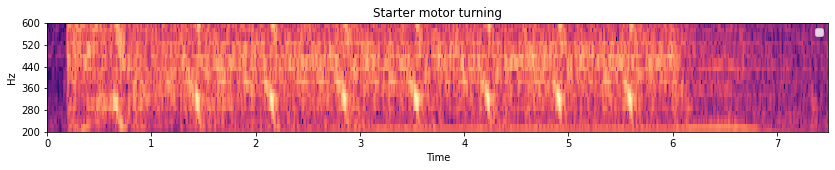

In [176]:
plt.figure(figsize=(14, 2))

plt.title("Starter motor turning")
librosa.display.specshow(mel_spec_dB, x_axis='time', y_axis='mel', sr=sample_rate, 
                         fmax=sample_rate/2, hop_length=hop_len)

plt.yticks(np.linspace(starter_min_freq, starter_max_freq, 6))
plt.ylim(starter_min_freq, starter_max_freq)

plt.legend(loc="upper right")

__Mel scale spectrogram__

Applying mel filter banks to the STFT helps hugely to see the motor frequency dropping as it comes under load during the compression stroke. The motor spins at about 400Hz and drops to 250Hz under load.

Let's do some calculations here to figure out the ratio between crankshaft spinning and the starter motor.

__RPM of the crankshaft__

$$680ms = \text{two crankshaft turns}$$

$$\text{1 crank turn} = \frac{680}{2} = 340ms$$

$$\text{Freq} = \frac{1000ms}{340ms} = 2.94Hz$$

$$\text{RPM} = 2.94Hz \cdot 60s = 176.4$$

__RPM of the starter motor__

$$\text{Number of flywheel teeth} = 132$$
$$\text{Number of starter motor teeth} = 10$$
$$\text{Gear ratio} = \frac{132}{10} = \frac{13.2}{1}$$
$$\text{Starter Motor Freq} = \frac{13.2 \cdot 2.94Hz}{1 \cdot 2.94Hz} = \frac{38.81}{2.94} = 38.81Hz$$
$$\text{Starter Motor RPM} = 38.81Hz \cdot 60s = 2828.48$$

The frequency of interest here is the starter motor frequency. However, if our calculations are correct, the starter motor fundamental frequency is not what is being observed here as it is actually much lower frequency. It could possibly be harmonics of that frequency that we are seeing. However, if that was the case then we'd be seeing the 10th or 11th harmonic which is not very likely because the magnitude typically decreases as harmonics increase.

__What is this sound?__

$$\text{Number of flywheel teeth} = 132$$
$$\text{Crankshaft freq} = 2.94Hz$$
$$\text{Flywheel tooth freq} = 132 \cdot 2.94Hz = 388.08Hz$$

The flywheel tooth frequency looks more like it. We're listening to a clank that is made each time another flywheel tooth makes contact with the starter motor.

So if we can figure out how many teeth there are on the flywheel, we can use this frequency to give us an instantaneous crankshaft speed.

To further add to this analysis, when it becomes harder to turn the crankshaft, the motor comes under more load, slowing down but also causing a louder noise because there is more force creating the noise hence why it appears as such in the spectrogram.

__Spectral Centroid__

Now that we know what the signal in this region of the spectrogram represent we need a way to be able to extract it. This is where the spectral centroid comes in. It is essentially a weighted mean that selects the frequency bin of the greatest magnitude for each frame of the spectrogram. So in this case, the spectral centroid represents the frequency of the flywheel teeth moving.

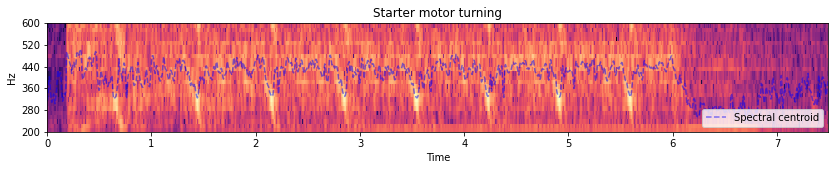

In [526]:
plt.figure(figsize=(14, 2))

starter_min_freq = 200
starter_max_freq = 600

selected_freqs = [i for i in range(len(mel_freqs))
                  if mel_freqs[i] <= starter_max_freq and mel_freqs[i] >= starter_min_freq]

# Calculate spectral centroid
mel_spec_no_phase, _ = librosa.magphase(mel_spec)
centroid = librosa.feature.spectral_centroid(
    S=mel_spec_no_phase[selected_freqs[0]:selected_freqs[-1]+1],
    freq=np.array([mel_freqs[i] for i in selected_freqs]),
)[0]

plt.title("Starter motor turning")
librosa.display.specshow(mel_spec_dB, x_axis='time', y_axis='mel', sr=sample_rate, 
                         fmax=sample_rate/2, hop_length=hop_len)

# Plot spectral centroid.
t = np.linspace(0, len(samples)/sample_rate, len(centroid))
plt.plot(t, centroid, color='b', linestyle="--", alpha=0.5, label="Spectral centroid")

plt.yticks(np.linspace(starter_min_freq, starter_max_freq, 6))
plt.ylim(starter_min_freq, starter_max_freq)

plt.legend(loc="lower right")

In [527]:
comps, acts = librosa.decompose.decompose(mel_spec[selected_freqs[0]:selected_freqs[-1]+1], n_components=4)

/usr/local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/usr/local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/usr/local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


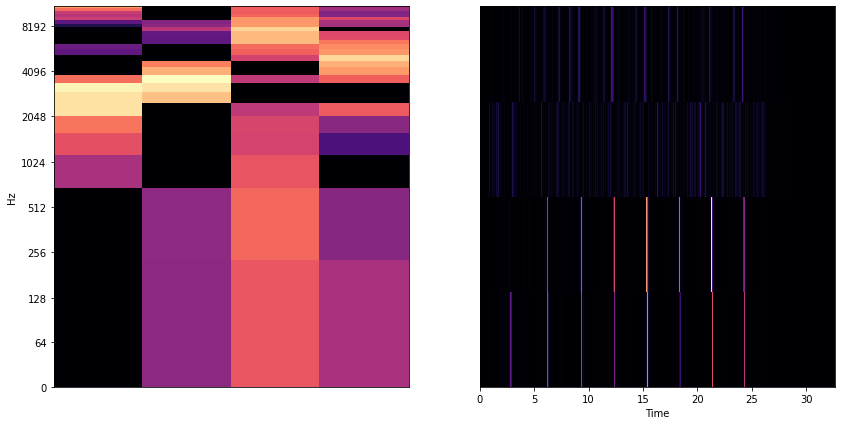

In [528]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

librosa.display.specshow(librosa.amplitude_to_db(comps, ref=np.max), y_axis='log', ax=ax[0])
librosa.display.specshow(acts, x_axis='time', ax=ax[1])

In [530]:
comps.shape

(25, 4)

__2. Cylinder head leaks__

In [535]:
# Frequency range to consider for cylinder head leaks.
starter_min_freq = 14000
starter_max_freq = 24000

selected_freqs = [i for i in range(len(mel_freqs))
                  if mel_freqs[i] <= starter_max_freq and mel_freqs[i] >= starter_min_freq]

In [536]:
# Calculate max freq bin.
mel_spec_no_phase, _ = librosa.magphase(mel_spec)
max_freqs = np.array([mel_freqs[np.argmax(frame) + selected_freqs[0]]
                      for frame in mel_spec_no_phase[
                          selected_freqs[0]:selected_freqs[-1]+1].T])

(0.5, 6.5)

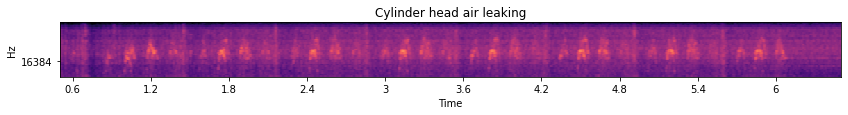

In [567]:
plt.figure(figsize=(14, 1))
plt.title("Cylinder head air leaking")
librosa.display.specshow(mel_spec_dB, x_axis='time', y_axis='mel', sr=sample_rate, 
                         fmax=sample_rate/2, hop_length=hop_len)
plt.ylim(starter_min_freq, starter_max_freq)
plt.xlim(xlim[0], xlim[1])

# If you want to save this to an image you can:
# plt.savefig('whistle.png')

__Patterns__

The vertical lines in the spectrogram are where cylinder 1 is coming under compression.

The leaking whistling sound can be seen as a sort of a negative quadratic curve. Interestingly, the middle cylinder seems to have the most pronounced shape in the spectrogam. I am not sure why this is exactly. It could very well be down to the window sizing so I will investigate this further, later.

(2.4, 2.5)

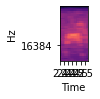

In [572]:
plt.figure(figsize=(0.5, 1))
librosa.display.specshow(mel_spec_dB, x_axis='time', y_axis='mel', sr=sample_rate, 
                         fmax=sample_rate/2, hop_length=hop_len)
plt.ylim(starter_min_freq, starter_max_freq)
plt.xlim(2.4, 2.5)

Another interesting pattern to note is that there appears to be two distinct whistling sounds, slightly offset from each other both spatially and temporally. Again I'm not entirely sure what this is. I'm not even sure whether the whistling sound is coming from down-stroke, up-stroke cylinders, or both. If we look at what's happening from a timing perspective, there are:

- two cylinders on an up stroke (compression and exhaust)
- two cylinders on a down stroke (intake and power)

There are some possibilities here. Either:

1. The sound is coming from the up-stroke or down-stroke cylinders only and the reason for distinct whistles is because of a slight difference in the piston lengths.
2. One whistle is coming from the up-stroke cylinders and the other distinct whistle is from the down-stroke cylinders.

One way to find this out is by recording with cylinders covered and see what the results are. I performed this experiment and it should be documented in the `cylinder-leak-sources` notebook. The results were that:

- The __compression stroke__ produces a whistle.
- The __power stroke__ produces a whistle.

The overlapping whistles is from the compression stroke of one cylinder and power stroke of another cylinder.

Why does it only happen on compression and power strokes? Because the valves are open on the intake and exhaust strokes so there are more places for the air to escape.

In [537]:
# Calculate time domain signal.
clip = librosa.istft(mel_spec_no_phase[selected_freqs[0]:selected_freqs[-1]+1])

In [538]:
clip.shape

(21060,)

In [539]:
# Novelty function.

"""
novelty = librosa.onset.onset_strength(y=clip)
plt.figure(figsize=(14, 7))
plt.plot(novelty)
"""

rmse = librosa.feature.rms(clip, frame_length=64, hop_length=128, center=True)[0]
rmse_diff = np.zeros_like(rmse)
rmse_diff[1:] = np.diff(rmse)

rmse_diff_2 = np.zeros_like(rmse)
rmse_diff_2[2:] = np.diff(np.flip(rmse), n=2)
rmse_diff_2 = np.flip(rmse_diff_2*-1)

energy_novelty = np.max([np.zeros_like(rmse_diff_2), rmse_diff_2], axis=0)
i_energy_novelty = np.min([np.zeros_like(rmse_diff), rmse_diff], axis=0)

energy_novelty.shape

(165,)

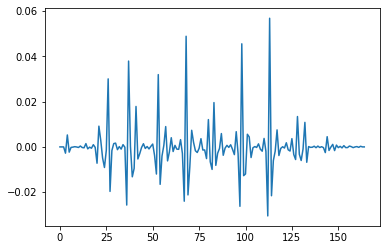

In [540]:
plt.plot(rmse_diff_2)

In [541]:
novelty_peaks, _ = find_peaks(energy_novelty, distance=1, height=0.005)
i_novelty_peaks, _ = find_peaks(i_energy_novelty*-1, distance=1, height=0.001)

In [542]:
t = np.linspace(0, len(samples)/sample_rate, len(energy_novelty))
novelty_peaks_t = [t[i] for i in novelty_peaks]
i_novelty_peaks_t = [t[i] for i in i_novelty_peaks]

In [543]:
# Get whistle candidate segments.
segments = [[n, next(i_n for i_n in i_novelty_peaks_t if i_n > n)] for n in novelty_peaks_t]

/usr/local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/usr/local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


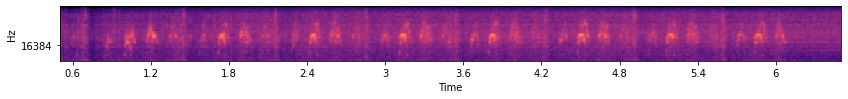

In [544]:
plt.figure(figsize=(14, 1))
librosa.display.specshow(mel_spec_dB, x_axis='time', y_axis='mel', sr=sample_rate, 
                         fmax=sample_rate/2, hop_length=hop_len)
plt.ylim(starter_min_freq, starter_max_freq)
plt.xlim(xlim[0], xlim[1])
plt.savefig('whistle.png')

(0.5, 6.5)

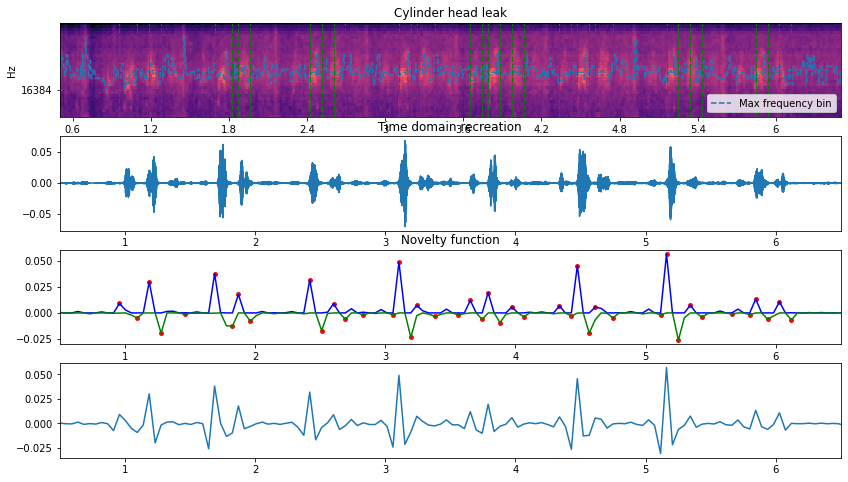

In [545]:
rows = 4
xlim = [0.5, 6.5]
fig, ax = plt.subplots(rows, 1, figsize=(14, 2*rows))

ax[0].set_title("Cylinder head leak")
librosa.display.specshow(mel_spec_dB, x_axis='time', y_axis='mel', sr=sample_rate, 
                         fmax=sample_rate/2, hop_length=hop_len, ax=ax[0])

ax[0].set_ylim(starter_min_freq, starter_max_freq)
ax[0].set_xlim(xlim[0], xlim[1])

# Plot max freq bins.
t = np.linspace(0, len(samples)/sample_rate, len(max_freqs))
ax[0].plot(t, max_freqs, linestyle="--", label="Max frequency bin")

for seg in segments:
    ax[0].axvline(x=seg[0], color='g', dashes=(5, 2), linewidth=1)
    ax[0].axvline(x=seg[1], color='g', dashes=(5, 2), linewidth=1)

ax[0].legend(loc="lower right")

# Plot time domain signal.
ax[1].set_title("Time domain recreation")
t = np.linspace(0, len(samples)/sample_rate, len(clip))
ax[1].plot(t, clip)
ax[1].set_xlim(xlim[0], xlim[1])

# Plot novelty.
ax[2].set_title("Novelty function")

t = np.linspace(0, len(samples)/sample_rate, len(energy_novelty))
ax[2].plot(t, energy_novelty, color='b')
ax[2].plot(t, i_energy_novelty, color='g')

# Novelty peaks.
t = np.linspace(0, len(samples)/sample_rate, len(energy_novelty))
novelty_y = [energy_novelty[i] for i in novelty_peaks]
ax[2].scatter(novelty_peaks_t, novelty_y, color='r', s=15)

# Inverse novelty peaks.
i_novelty_y = [i_energy_novelty[i] for i in i_novelty_peaks]
ax[2].scatter(i_novelty_peaks_t, i_novelty_y, color='r', s=15)

ax[2].set_xlim(xlim[0], xlim[1])

ax[3].plot(t, rmse_diff_2)
ax[3].set_xlim(xlim[0], xlim[1])

__Potential algorithm for highlighting whistling sounds__

~~1. Use onset detection to mask the potential whistling sounds.~~

~~2. Either find the point of highest magnitude in the region or try to find the top of the parabola.~~

~~3. Change the size of the parameters of the parabola to maximise the fit.~~

1. Use onset detection to mask the potential whistling sounds.

2. Use Non-negative matrix decomposition and check for a certain signature in the first component as well as activation of it in the potential whistling sound.

3. If found, it is a whistling sound.

In [546]:
mel_spec_dB_denoise = librosa.decompose.nn_filter(mel_spec_dB, aggregate=np.average, metric='cosine')

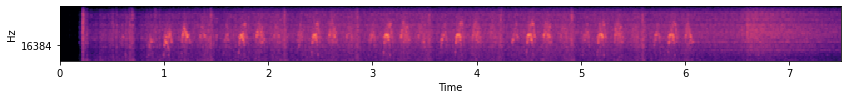

In [552]:
plt.figure(figsize=(14, 1))
librosa.display.specshow(mel_spec_dB, x_axis='time', y_axis='mel', sr=sample_rate, 
                         fmax=sample_rate/2, hop_length=hop_len)

plt.ylim(starter_min_freq, starter_max_freq)
plt.savefig('whistle_denoise.png')

In [563]:
comps, acts = librosa.decompose.decompose(mel_spec[selected_freqs[0]:selected_freqs[-1]+1], n_components=10)

/usr/local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


/usr/local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/usr/local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


(0.0, 7.48975)

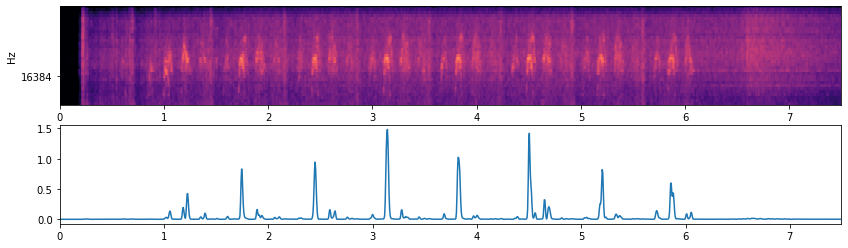

In [562]:
t = np.linspace(0, len(samples)/sample_rate, len(acts[0]))
fig, ax = plt.subplots(2, 1, figsize=(14, 4))

librosa.display.specshow(mel_spec_dB, x_axis='time', y_axis='mel', sr=sample_rate, 
                         fmax=sample_rate/2, hop_length=hop_len, ax=ax[0])
ax[0].set_ylim(starter_min_freq, starter_max_freq)

ax[1].plot(t, acts[0])
ax[1].set_xlim(0, t[-1])

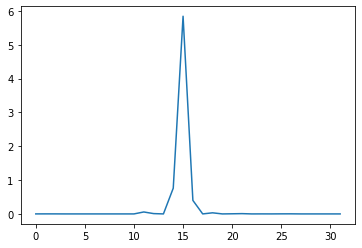

In [550]:
plt.plot(comps.T[0])

/usr/local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/usr/local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/usr/local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


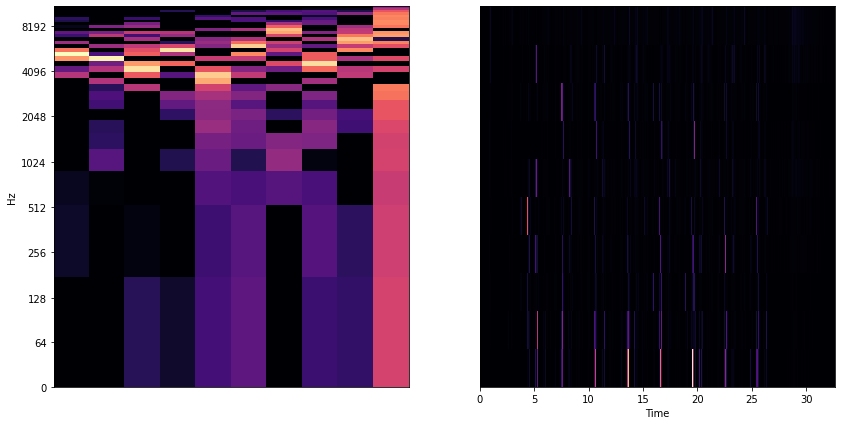

In [551]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

librosa.display.specshow(librosa.amplitude_to_db(comps, ref=np.max), y_axis='log', ax=ax[0])
librosa.display.specshow(acts, x_axis='time', ax=ax[1])